# Início: 25/06/2021

No Capítulo 1, vimos que a regressão (previsão de valores) e classificação (previsão de classes) são as tarefas de aprendizado supervisionado mais comuns de se fazer. No Capítulo 2, usamos alguns algoritmos como a Regressão Linear, Árvore de Decisão e Florestas Aleatórias para prever os preços do mercado imibiliário. Agora, neste capítulo voltaremos nossa atenção para os sistemas de classificação.

### MNIST

O conjunto de usado será o MNIST, que conta com 70 mil pequenas imagens de dígitos escritos a mão (para mais detalhes, acesse: https://en.wikipedia.org/wiki/MNIST_database). Cada imagem é rotulada com um dígito que a representa. Como esse conjunto de dados é muito estudado e utilizado, muitas vezes é conhecido como "Hello World" do Aprendizado de Máquina: sempre que as pessoas criam um novo algoritmo de classificação, elas têm curiosidade de saber o desempenho no MNIST. Se começamos a estudar o Aprendizado de Máquina, mais cedo ou mais tarde bateremos de frente com o MNIST.

O Scikit-Learn oferece diversas funções que auxiliam em baixar o conjunto de dados populares. O MNIST é um deles. O script abaixo faz isso:

In [1]:
import numpy as np

In [2]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [3]:
from sklearn.datasets import fetch_openml

In [4]:
import time

In [5]:
tempo_inicial = time.time()
mnist = fetch_openml('mnist_784', version=1, cache=True,
                    as_frame=False)
mnist.target = mnist.target.astype(np.int8) # fetch_openml() retorna os valores em 'target' como strings
sort_by_target(mnist) # fetch_openml() retorna um dataset fora de ordem

mnist['data'], mnist['target']
tempo_final = time.time() - tempo_inicial
print(f'Tempo de espera: {tempo_final :.2f} segundos.')

Tempo de espera: 41.18 segundos.


O conjunto de dados carregados pelo Scikit-Learn na maior parte das vezes possuem uma estrutura parecida com um dicionário:
- Uma chave **DESCR** que tem descrição sobre os dados;
- Uma chave **data** que possui um array com uma linha por instância e uma coluna por característica e;
- Uma chave chamda **target** com um array dos rótulos.

Vejamos estes arrays:

In [6]:
X, y = mnist['data'], mnist['target']

In [7]:
X.shape

(70000, 784)

In [8]:
y.shape

(70000,)

Existe 70 mil imagens e cada uma dessas imagens possui 784 características. Isso acontece porque cada imagem possui 28 x 28 pixels (total de 784 pixels), e cada uma dessas características representa a intensidade de um pixel; variando de 0 (branco) a 255 (preto). Sabendo disso, vamos dar uma olhada em um dígito do conjunto de dados. Usando a função **imshow()** do matplitlib, precisaremos somente do vetor de característica de uma instância, formatá-lo para 28 x 28 pixels e mostrá-lo na tela:

In [9]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

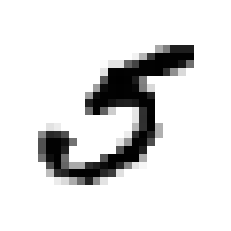

In [10]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary,
          interpolation='nearest')

plt.axis('off')
plt.show()

Isso parece um 5, o que o rótulo nos diz?

In [11]:
y[36000]

5

A imagem abaixo apresenta outras imagens do conjnto de dados MNIST para termos uma ideia da complexidade da tarefa de classificação:
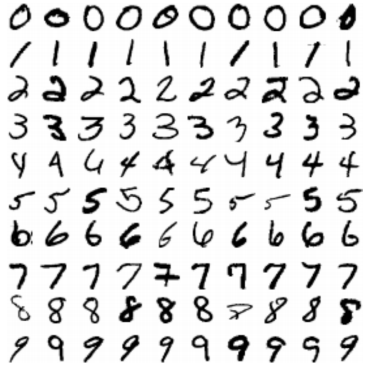

Mas alto lá! Sempre devemos criar um conjunto de teste e deixá-lo de lado antes de analisar os dados de perto. O conjunto de dados MNIST já está dividido em um conjunto de treinamento, com as primeiras 60 mil imagens como os dados de treino e os 10 mil finais como dados de teste:

In [12]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Além de separar, vamos embaralhar os dados; isso garante que todos os subconjuntos da validação cruzada sejam semelhantes (isso segura que nenhum subconjunto ficará sem algum dígito). Além disso, alguns algoritmos são sensíveis em relação a ordem de instâncias de treinamento, e, se obtiverem muitas instâncias similares, não funcionarão bem. Ou seja, embaralhar o conjunto de dados impede que isso aconteça:

In [13]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

### Treinando um Classificador Binário

Por ora, vamos simplificar o problema. A tentativa agora é identificar apenas um dígito, por exemplo o número 5. Este "5-detector" será um exemplo de *classificador binário* capaz de distinguir apenas entre duas classes: o que é 5 e o que não é 5. Vamos criar os vetores-alvo para esta tarefa de classificação:

In [14]:
## True par todos os 5, False para todos os outro dígitos
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Certo, agora é a hora de escolher um classificador e treiná-lo. Um bom classificador para começar é o *Gradiente Descendente Estocástico* (SGD, do inglês) com a utilização da classe **SGDClassifier**. Este classificador tem a vantagem de conseguir lidar de maneire eficiente com um conjunto de dados enorme. O fato do SGD lidar com grande quantidade de dados, faz com que seja possível trablhar de maneira independente com instâncias de treinamento, sendo também uma ótima opção para o *aprendizado online*. Vamos criar esse classificador e treiná-lo em todo o conjunto de treino (os 60 mil dados):

In [15]:
from sklearn.linear_model import SGDClassifier

In [16]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Agora podemos chamá-lo para detectar as imagens do número 5:

In [17]:
sgd_clf.predict([some_digit])

array([ True])

O classificador supõem que a imagem é um 5 (True). Parece que adivinhou corretamente nesse caso! Agora, é hora de avaliar o desempenho desse modelo.

### Medições de Desempenho

Fazer a avaliação de um classificador é diversas vezes significativamente mais complicado do que avaliar um regressor, portanto, um grande parte desse capítulo será dedicado a esse tópico.

**Medição da Acurácia com a Utilização da Validação Cruzada**

A função usada será  **cross_val_score()** (a mesma usada no Capítulo 2) para avaliar o nosso modelo **SGDClassifier** com a utilização da validação cruzada *K-fold* com três partes:

In [18]:
from sklearn.model_selection import cross_val_score

In [19]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3,
               scoring='accuracy')

array([0.9623 , 0.956  , 0.94085])

Excelente! Acima de 95% de acurácia (taxa das previsões) em todas as partes da validação cruzada? Uma ótima notícia, não? Bem, antes que fiquemos animados, vejamos um classificador fraco que apenas classifica cada imagem na classe "não 5":

In [20]:
from sklearn.base import BaseEstimator

In [21]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

Será que conseguir adivinhar a acurácia desse modelo? Vamos descrobrir:

In [22]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3,
               scoring='accuracy')

array([0.9092 , 0.91085, 0.9089 ])

Sim, mais de 90% de acurácia! Isso acontece porque apenas cerca de 10% das imagens são "5", portanto, se quisermos adivinhar que uma imagem **não** é um "5", estaramos certos em 90% das vezes.

Isso mostra o motivo da acurácia não ser a medida preferencial de desempenho para os classificadores, particularmente quando estivermos trabalhando com *conjunto de dados assimétricos*, isto é: quando algumas classes forem mais frequentes que outras).

**Matriz de Confusão**

Uma forma de avaliar melhor a performance de um classificador é analisar a *matriz de confusão*. A ideia por trás é contar o número de ocorrências que as instâncias da classe A são classificadas como classe B. Por exemplo, para saber o número de vezes que o classificador confundiu imagens "5" com "3", olhariamos na 5ª linha e na 3ª coluna da matriz de confusão.

Para calcular a matriz de confusão, primeiro precisamos ter um conjunto de previsões para que possam ser comparadas com alvos reais. Podemos fazer previsões no grupo de testes, mas não vamos mexer nele por agora (vale lembrar que esse grupo é para ser usado antes de lançar o modelo). Ao invés disso, vamos utilizar a função **cross_val_predict()**:

In [23]:
from sklearn.model_selection import cross_val_predict

In [24]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5,
                                cv=3)

Assim como **cross_val_score()**, a **cross_val_predict()** desempenha a validação cruzada *K-fold*, porém, ao invés de devolver as pontuações da avaliação, ela retorna as previsões feitas em cada parte do teste. Isso siginifica que obtemos uma previsão limpa para cada instância no conjunto de treinamento, sendo "limpa" a previsão que é realizada por um modelo que nunca viu os dados durante o treinamento.

Chamando a função **confusion_matrix()**, estamos prontos para obter a matriz de confusão. Basta informar apenas a classe alvo (y_train_5) e as classe previstas (y_train_pred):

In [25]:
from sklearn.metrics import confusion_matrix

In [26]:
confusion_matrix(y_train_5, y_train_pred)

array([[53011,  1568],
       [ 1249,  4172]], dtype=int64)

Cada linha em uma matriz de confusão representa uma *classe real*, enquanto cada coluna, uma *classe prevista*. A primeira linha da matriz considera imagens não 5 (a *classe negativa*): 53849 delas foram classificadas como não 5 (conhecidas como *verdadeiros negativos*), enquanto os 730 foram erroneamente classificados como 5 (*falsos positivos*). A segunda linha considera as imagens dos 5 (a *classe positiva*): 1523 foram classificadas de maneira errada como não 5 (*falso negativo*), enquanto 3898 foram classificados como 5 (*verdadeiros positivos*). Um classificador perfeito teria apenas verdadeiros positivos e verdadeiros negativos, portanto a matriz de confusão teria valores diferentes de 0 em sa diagonal principal.

A matriz de confusão fornece muitas informações, porém pode ser que preferiramos uma métrica mais concisa. Um ponto interessante a observarmos é a acurácia das previsões positivas; que é conhecida de *precisão* do classificador, como mostra a imagem a seguir:
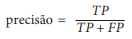
Onde: TP é o número de verdadeiros positivos e FP o número de falsos positivos.

Uma maneira comum de ter a precisão perfeita é fazer uma única previsão positiva e garantir que esteja correta (precisão 1/1 = 100%). Isso não é nada útil, já que o classificador ignoraria todas, menos uma instância positiva. Logo, a precisão é usada em conjunto com outra métrica chamada *revocação*, também conhecida como *sensibilidade* ou *taxa de verdadeiros positivos* (TPR, do inglês): esta é a taxa de instâncias positivas que são corretamente detectadas pelo classificador. como visto na imagem a seguir:
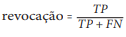
Onde: FN representa o número de falsos negativos.

A imagem a seguir explica melhor:
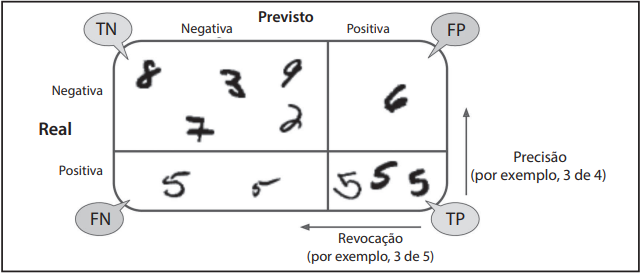

**Precisão e Revocação**

O Scikit-Learn oferece diversas funções para calcular métricas classificadoras, incluindo precisão e revocação:

In [27]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [28]:
# 3898 / (3898 + 714)
precision_score(y_train_5, y_train_pred)

0.7268292682926829

In [29]:
# 3898 / (3898 + 1523)
recall_score(y_train_5, y_train_pred)

0.7695997048515034

Agora, o nosso *5-detector* não parece ser tão brilhante assim. Quanto ele afirma que uma imagem represeta um 5, ele está correto somente em 84% dos casos. Além disso, ele detecta somente 72% dos "5".

Diversas vezes, é conveniente combinar a precisão e revocação em uma única métricha conhecida como *pontuação F1*, principalmente se temos que comparar dois classificadores de forma simples. A pontuação F1 é a *média harmônica* da precisão e revocação (imagem a seguir). Enquanto a média regular trata por igual todos os valores, a média harmônica fornece peso maior aos valores mais baixos. Como resultado, o classificador só obterá uma pontuação F1 alta se a revocação e precisão forem altas:
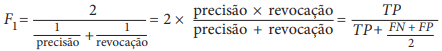

Para calcular a pontuação F1, basta chamar a função **f1_score()**:

In [30]:
from sklearn.metrics import f1_score

In [31]:
f1_score(y_train_5, y_train_pred)

0.7476032613565092

A pontuação F1 favorece classificadores com precisão e revocação parecidos. Porém, nem sempre é o que queremos: em alguns casos, a nossa preocupação é com a precisão, e em otros, com a revocação. Por exemplo, se treinamos um classificador para detectar vídeos que são adequados para crianças, bem provável que prefeririamos um classificador que rejeitasse muitos bons vídeos (baixa revocação), mas que mantivesse somente os adequados (alta precisão); em detrimento de um classificador que tivesse uma revocação alta, mas isso permitiria que alguns vídeos ruins aparecesse em nossos produtos (em casos como esse, é sempre bom passar por uma verificação humana). Por outro lado, imagine que treinamos um classificador para detectar bandidos nas imagens do sistema de segurança: é algo tranquilo se o nosso classificador tiver uma precisão de apenas 30%, desde que sua revocação seja de 99% (bem provável que os guardas receberão alguns alertas falsos, mas quando quase todos os ladrões serão presos).

Infelizmente, é impossível ter os dois: aumentar a revocação e diminuir a precisão, e vice-versa. Isso é chamado de *compensação da precisão/revocação*.

**Compensação da Precisão/Revocação**

Para entender melhor essa métrica, vejamos como o **SGDClassifier** toma suas decisões de classificação. Para cada instância, ele calcula uma pontuação baseada em uma *função de decisão* e, se essa pontuação for maior que o seu limiar, ele atribui a intância à classe positiva, o então a atribui à classe negativa. Suponha que o *limiar de decisão* seja posicionado na parte central: encontraremos 4 verdadeiros positivos ao lado direito e um falso positivo. Logo, a precisão é de 80% (4 de 5) com esse limiar. Mas a cada 6 dos 5 verdadeiros, o limiar detecta somente 4, portanto a revocação é de 67% (4 de 6). Agora, se amentarmos o limiar o falso positivo torna-se um verdadeiro negativo, aumentando a precisão (nesse caso, até 100%), porém um verdeiro positivo torna-se um falso negativo, diminuindo a revocação para 50%. Desse modo, diminuir o limiar aumenta a revocação e reduz a precisão. A imagem a seguir explicará melhor:
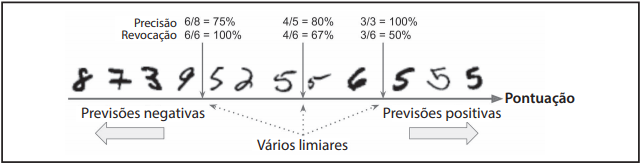

O Scikit-Learn não permite qe definamos o limiar diretamento, mas nos fornece acessos às pontações de decisão qe ele usa para as previsões. Ao invés de chamar o método *predict()* do classificador, podemos chamar o método *decision_function()*, que retorna uma pontuação para cada instância e, em seguida, realiza previsões com base nessas pontações usando qualquer limiar desejado:

In [32]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2545.98861462])

In [33]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

O **SGDClassifier** usa um limiar igual a 0, portanto o código acima retorna o mesmo resultado que o método *predict()* (no caso, True). Aumentaremos o limiar:

In [34]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

Isso confirma que se amentarmos o limiar, a revocação diminui. A imagem realmente representa um 5, e o claassificador detecta quando o limiar é 0, mas não consegue quando o limiar sobe para 200 mil.

Como que decidiremos qual limiar utilizar? Para isso, usaremos novamente a função *cross_val_predict()*. Primeiro necessitamos obter as pontuações de todas as instâncias no conjunto de treinamento, mas desta vez especificando o que desejamos que ela retorne as pontuações da decisão em vez das previsões:

In [35]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                            method='decision_function')

Agora, usando a função *precision_recal_curve()* é possível calcular a precisão e revocação para todos os limiares possíveis:

In [36]:
from sklearn.metrics import precision_recall_curve

In [37]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Finalmente, usando o matplotlib podemos plotar a precisão e revocação como funções de valor do limiar:

In [38]:
def plot_precision_recall_vs_threshold(precisions, recalls,
                                      thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--',
             label='Precisão')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Revocação')
    plt.xlabel('Threshold')
    plt.legend(loc='center left')
    plt.ylim([0, 1])

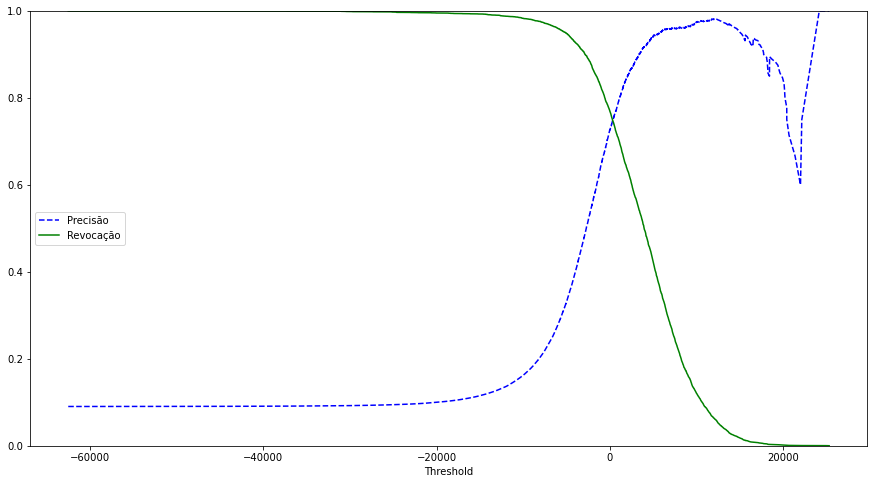

In [39]:
plt.figure(figsize=(15, 8))
plot_precision_recall_vs_threshold(precisions, recalls,
                                  thresholds)
plt.show()

Agora podemos selecionar o valor do limiar que nos fornece a melhor compreensão de precisão/revocação para a nossa tarefa. Outra maneira de selecionar uma boa compensação de precisão/revovação é plotar a precisão diretamente contra a revocação:

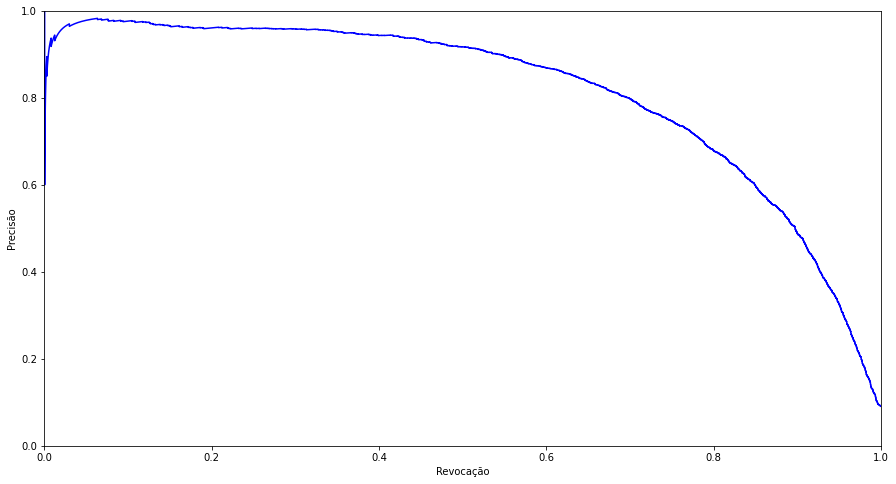

In [40]:
plt.figure(figsize=(15, 8))
plt.plot(recalls, precisions, 'b-')
plt.xlabel('Revocação')
plt.ylabel('Precisão')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

É notável que a precisão começa a cair de maneira vertiginosa perto dos 80% da revocação. Provavelmente selecionariamos uma compensação de precisão/revocação antes dessa queda, algo em torno dos 60%. Mas, é óbvio, que isso dependerá do projeto.

Então, vamos supor que almejamos 90% de precisão. Vemos na plotagem e desobrimos que precisamos de um limiar de 70 mil. Ao invés de chamar o *predict()* do classificador, podemos apenas executar o código a seguir para fazer as previsões (por enquanto, no conjunto de treinamento):

In [53]:
y_train_pred_90 = (y_scores > 70000)

Verificamos a precisão e a revocação dessas previsões:

Está tudo errado pelo livro e o código do cara não conta com isso. Vou deixar em aberto o final dessa parte! **ESTOU DE SACO CHEIO COM ISSO JÁ!!!**

**A Curva ROC**

A curva das *características operacionais do receptor* (ROC para a sigla em inglês) é outra ferramente que pode ser usada. Essa curva é semelhante a precisão/revocação, porém, ao invés de mostrar a precisão versus a revocação, a curva ROC plota a *taxa de verdadeiros positivos* (TPR, do inglês; outro nome par a *revocação*) contra a *taxa de falsos positivos* (FPR, do inglês). O *FPR* é a razão de instâncias classificadas como positivas mas são negativas. É a mesma coisa que 1 menos a *taxa de verdadeiros negativos* (TNR, do inglês), cuja é a razão de instâncias negativas que são corretamente classificadas como negativas. A *TNR* pode ser chamada de *especificidade*. Logo, a curva TOC mostra a *sensibilidade* (revocação) versus *1 - especificidade*.

Para mostrar a plotagem ROC, primeiro precisamos calcular a *TPR* e *FPR* para diversos valores de limiares usando a função **roc_curve()**:

In [41]:
from sklearn.metrics import roc_curve

In [42]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

A partir disso, usando o matplotlib é possível plotar a curva de FPR versus TPR:

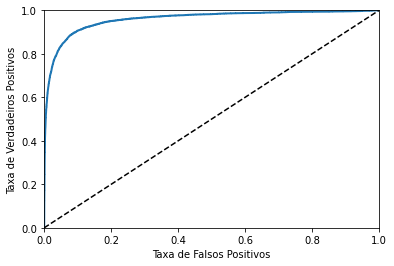

In [43]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
plot_roc_curve(fpr, tpr)
plt.show()

Outra vez, há ma compensação: quanto maior a revocação (TPR, taxa de verdadeiros positivos), maior é o número de falsos positivos (FPR). A linha pontilhada mostra a curva ROC de um classificador aleatório; um bom classificador fica longe dessa linha pontilhada, indo ao máximo do canto superior esquerdo possível.

Uma maneira, dentre várias, de comparar classificadores é medir a *área abaixo da curva* (AUC, do inglês). Um classificador perfeito possui um ROC AUC de 1, enquanto um classificador aleatório terá essa razão em 0,5. O Scikit-Learn disponibiliza uma função para calalar o ROC ACUC:

In [44]:
from sklearn.metrics import roc_auc_score

In [45]:
roc_auc_score(y_train_5, y_scores)

0.9592319886400897

Vamos treinar um **RandomForestClassifier** e comparar a curva ROC e a pontuação ROC AUC para o **SDGClassfier**. Primeiramente, precisamos obter as pontuação para cada uma das instâncias no conjunto de treinamento. Porém, devido a maneira de como opera, a classe **RandomForestClassifier** não possui um método **decision_function()**. Por outro lado, essa classe possui um método **predict_proba()**. Os classificadores do Scikit-Learn normalmente possuem um ou outro. O método **predict_proba** retorna um array que contém uma inha por instância e uma coluna por classe, cada uma contendo a probabilidade de a instância fornecida pertencer à classe informada (por exemplo, 70% da imagem ser realmente um 5):

In [46]:
from sklearn.ensemble import RandomForestClassifier

In [47]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train,
                                   y_train_5, cv=3,
                                   method='predict_proba')

Porém, para plotar uma curva ROC, precisamos da pontação, não da probabilidade. Uma maneira simples de contornar isso é utilizar a probabilidade da classe positiva como a ponruação:

In [48]:
y_scores_forest = y_probas_forest[:, 1] # pontuação = probabilidade de classe positiva
fpr_forest, tpr_forest, tresholds_forest = roc_curve(y_train_5, y_scores_forest)

Agora sim estamos com tudo pronto para plotar a curva ROC. É util plotar a primeira curva ROC junto para compararmos:

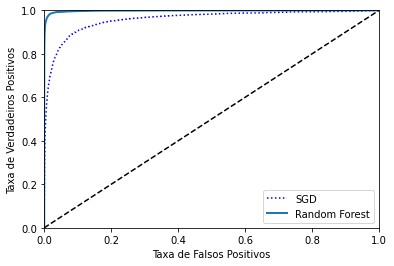

In [49]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

Como pode ser visto na imagem acima, a curva ROC do **RandomForestClassifier** parece bem melhor do que o **SGDClassifier**: a curva do primeiro classificador fica bem próxima ao canto superior esquerdo. Como consequência, a pontuação ROC AUC também é consideravelmente melhor:

In [50]:
roc_auc_score(y_train_5, y_scores_forest)

0.9980980607951138

### Classificadores Multiclasse

Enquanto os classificadores binários se distinguem em duas classes, os *classificadores multoclasses* (conhecidos como *classficadores multinomiais*) conseguem distinguir entre mais de duas classes.

Alguns algoritmos (como os de Floresta Aleatória ou Naive-Bayes) conseguem lidar diretamente com múltiplas classes. Outros (como Máqinas de Vetores de Suporte ou classificadores Lineares) são somente binários. Contudo, há diversas estrstégis que podemos utilizar para fazer a classificação multiclasse com classificadores binários múltiplos.

Por exemplo, uma forma de crirar um sistema que possa classificar as imagens numéricas em 10 classes (do 0 ao 9) é treinar 10 classificadores binários, um para cada dígito. Portanto, quando quisermos classificar uma imagem, obtemos a pontuação de decisão de cada classificador para essa imagem e selecionamos a classe cujo classificador produz a maior pontuação. Esse método é chamado de estratégia *um contra todos* (OvA, do inglês; chamada também de *one-versus-the-rest*).

Outra estratégia é treinar um classificador binário para cada par de dígitos 0s e 1s, outro classificador para distinguir 0s e 2s, outro para 1s e 2s e assim sucessivamente. O nome dessa estratégia é chamada de *um contra um* (OvO, do inglês). Se existir N classes, precisamos treinar **N x (N - 1) / 2** classificadores. Isso signfica que devemos treinar 45 classificadores binário para o problema do MNIST! Quando classificamos uma magem, devemos passá-la por todos os 45 classificadores e ver em qual classe há a maior pontuação. A principal vantagem de usar o OvO é que cada classificador necessita ser treinado somente um única vez para as duas classes que devem distinguir na parte do conjunto de treinamento.

Alguns algoritmos (como as Máquinas de Vetores de Suporte) escalam mal com o tamanho do conjunto de treinamento. Logo, para esses algoritmos o OvO é melhor, pois é mais rápido treinar muitos classificadores em pequenos conjuntos do que treinar alguns classificadores em grandes conjuntos (as partes somam mais do que o todo). Todavia, OvA é a melhor solução para a maiora dos algoritmos de classificação binária.

O Scikit-Learn detecta quando utilizamos um algoritmos de classificação binária em uma tarefa de classificação multiclasse e executa o OvA de maneira automática (exceto para SVM, onde o Scikit-Learn utiliza o OvO). Vamos tentar isso como o **SGDClassifier**:

In [51]:
sgd_clf.fit(X_train, y_train) # y_train, não y_train_5
sgd_clf.predict([some_digit])

array([5], dtype=int8)

Essa foi moleza! O código acima treina o **SGDClassifier** no conjunto de treinamento utilizando as classes-alvo originais de 0 a 9 (*y_train*) ao invés das classes-alvo 5 contra todos (*y_train_5*). Então, o modelo faz uma previsão (no caso, correta). Por trás das cortinas, o Scikit-Learn, na verdade, treinou 10 classificadores binários, analisou as pontuações de decisão e selecionou a classe que teve a maior pontuação.

Para vermos se este é realmente o caso, chamaremos o método **decision_function()**. Ao invés de retornar apenas uma pontuação por instância, teremos agora as 10 pontuações; uma por cada classe:

In [52]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[ -6636.09815712, -23158.14216527, -15519.36011704,
          -192.31257953, -18729.05927063,   1282.62256101,
        -24379.60907905,  -9611.07986194, -11473.4877692 ,
        -16817.06929525]])

Como visto, a pontuação da classe referente ao dígito "5" é mais alta:

In [53]:
np.argmax(some_digit_scores)

5

In [54]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [55]:
sgd_clf.classes_[5]

5

Se quisermos forçar o Scikit-Learn a usar o método *um contra um* ou *um contra todos*, podemos usar a classe **OneVsOneClassifer** ou a **OneVsRestClassifier** respectivamente. Criaremos uma instância e passaremos um classificador binário para o nosso construtor. Por exemplo, usando a estratégia OvO, com base no **SGDClassifier**, o código a seguir cria um classificador multiclasse:

In [56]:
from sklearn.multiclass import OneVsOneClassifier

In [57]:
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=int8)

In [58]:
len(ovo_clf.estimators_)

45

Treinar um **RandomForestClassifier** é muito fácil:

In [59]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=int8)

Dessa vez, o Scikit-Learn não precisou exectar o OvA ou OvO porque os classificadores da Floresta Aleatória têm a capacidade de classificar instâncias diretamente em múltiplas classes. Podemos chamar o **predict_proba()** para obtermos a lista de probabilidades que o classificador atribuiu a cada instância para cada classe:

In [60]:
forest_clf.predict_proba([some_digit])

array([[0.08, 0.  , 0.  , 0.05, 0.01, 0.84, 0.  , 0.01, 0.01, 0.  ]])

Podemos notar que a confiança do classificador está bem elevada: 84% de chances de a imagem representar o dígito "5".

Agora devemos avaliar os classificadores. Por padrão, usaremos a validação cruzada. Vamos analisar a precisão do **SGDClassifier** utilizando a função **cross_val_score()**:

In [61]:
cross_val_score(sgd_clf, X_train, y_train, cv=3,
               scoring='accuracy')

array([0.8831 , 0.88355, 0.8517 ])

O classificador em questão consegue uma precisão de 85% em todas as partes do teste. Se utilizarmos um classificador aleatório, teremos somente 10% de precisão, então não é uma pontuação tão ruim assim, mas podemos melhorar. Por exemplo, dimensionar as entradas aumenta a precisão para mais de 90% (como explicado no capítulo 2):

In [62]:
from sklearn.preprocessing import StandardScaler

In [63]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3,
               scoring='accuracy')

array([0.9021, 0.9007, 0.898 ])

### Análise de Erro

Em um projeto real, seguiríamos as etapas de uma lista de verificação do projeto de Aprendizado de Máquina (Apêndice B do livro): explorar opções de preparação de dados, testar diversos modelos e ajustar os hiperparâmetros com o **GridSearchCV**, e claro, autimatizando o máximo que der. Por ora, vamos considerar que possuímos um modelo promissor e qeuremos encontrar maneiras de melhorá-lo. Uma ideia simples é analisar os tipos de erros que ele comete.

Primeiramente, vamos olhar para uma matriz de confusão. Precisamos realizar previsões com a função **cross_val_predict()**, então chamar a função **confusion_matrix()**:

In [65]:
# Isso aqui leva um tempo considerável!!!
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled,
                                y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5579,    0,   17,    6,    8,   41,   34,    6,  231,    1],
       [   1, 6415,   45,   24,    3,   48,    5,    8,  181,   12],
       [  28,   25, 5240,   89,   68,   24,   73,   41,  362,    8],
       [  28,   21,  111, 5238,    2,  208,   24,   41,  398,   60],
       [  11,   13,   46,   12, 5236,    8,   39,   16,  306,  155],
       [  27,   18,   28,  148,   48, 4477,   82,   17,  509,   67],
       [  29,   18,   47,    2,   42,   97, 5544,    8,  130,    1],
       [  20,   10,   52,   25,   57,    9,    4, 5700,  178,  210],
       [  15,   65,   38,   98,    1,  108,   31,    6, 5446,   43],
       [  23,   21,   30,   64,  130,   29,    1,  171,  339, 5141]],
      dtype=int64)

São muitos números mostrados. Vamos usar a função **matshow()** de Matplotlib, é bem mais fácil entender essa matriz de confusão de maneira visual.

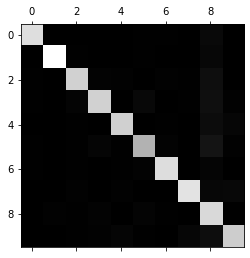

In [66]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

Essa matriz de confusão está boa, uma vez que a maioria das imagens está na diagonal principal, o que indica que foram classificadas de maneira correta. Os "5" parecem um pouco mais escuros do que o restante, o que pode indicar duas coisas: há poucas imagens "5" no conjunto de dados ou o classificador não funcionou muito bem no "5" como nos outros dígitos. O bom é que conseguimos saber que ambos são o caso.

Analisaremos a plotagem dos erros. Primeiramente, devemos dividir cada valor na matriz pelo número de imagens na classe correspondente para que possamos comparar as taxas de erro ao invés do número absoluto de erros (o que tornaria as classes mais frequentes parecerem injustamente mal arrumadas):

In [67]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Agora, a diagonal principal sera preenchida com 0s para manter apenas os erros de plotar o resultado:

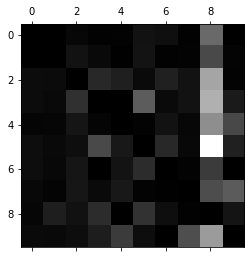

In [68]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Na plotagem acima, podemos ver claramente os tipos de erros que o classificador comete. Vale lembrar que as linhas representam as classes reais e as colunas, as classes previstas. A coluna para a classe 8 é bem chamativa, o que indica que muitas imagens estão classificadas erradas como 8. Da mesma maneira, a linha para a classe 5 é chamativa, o que indica que 5 é confudido com outro dígito. Por outro lado, algumas linhas são bem escuras, como a linha 1: isso mostra que a maioria dos 1s são classificados corretamente (poucos são confunididos com 8). Vale observar que os erros não são simétricos; por exemplo, existe mais 5 classificados de maneira errada como 8 do que o inverso.

Analisar essa matriz nos fornece informações sobre maneiras de melhorar nosso classificador. Olhando para a plotagem, notamos que nossos esforços devem ser focados na melhoria da classificação de 8 e 5, bem como corrigir a pequena confusão do 3/5. Por exemplo, poderiamos tentar reunir mais dados de treinamento para esses dígitos em questão. Ou ainda, criar novas características que ajudassem o classificador - por exemplo, escrever um algoritmo para contar o número de curvas fechadas (exemplo: 8 tem duas, 6 tem uma, 5 não tem). Além disso, poderiamos pré-processar as imagens (usando as bibliotecas Scikit-Image, OpenCV ou Pillow, como exemplos) para que alguns padrões fossem destacados, como as curvas fechadas.

Analisar erros individuais também é uma ótima maneira de obter informações sobre o que o nosso classificador está fazendo  por que ele está falhando, mas é mais demorado e difícil. Por exemplo, vamos plotar exemplos de 3 e 5:

In [76]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size, size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row: (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap=matplotlib.cm.binary, **options)
    plt.axis('off')

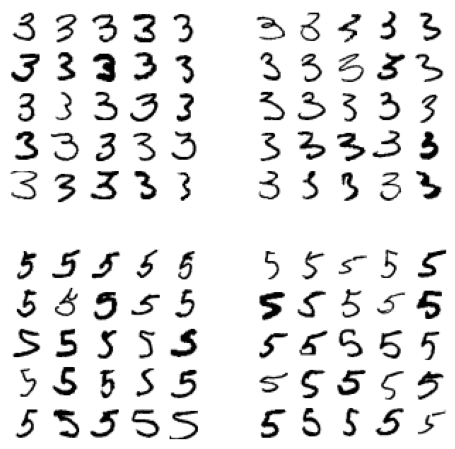

In [77]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8, 8))

plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

plt.show()

Os dois blocos 5x5 à esquerda mostram dígitos classificados como 3 e à direita, as imagens classificadas como 5. Alguns dígitos que o classificador errou (blocos inferior esquerdo e superior direito), por exemplo, na primeira linha na 7ª coluna é difícil até de um humano saber se é um 8 ou 3. Contudo, a maioria das imagens mal classificadas parece erros óbvios para nós humanos, e é difícil compreender o motivo do classificador ter errado. A razão disso é que samos um **SDGClassifier** simples, cujo é um modelo linear. Tudo o que esse modelo faz é atribuir um peso por classe a cada pixel, e, quando ele observa uma nova imagem, apenas resume as intensidades dos pixels analisados para retornar uma pontuação para cada classe. Portanto, como 3 e 5 diferem apenas em alguns pixels, o modelo em questão irá confundí-los com certa facilidade.

A notável diferença entre um 3 e um 5 é a posição da linha que une a parte superior ao arco inferior. Se desenharmos um 3 com essa linha um pouco deslocada para a esquerda, o classificador pode analisar isso como um  5 e vice-versa. De modo geral, esse classificador é bem sensível à mudança de imagem e sua rotação. Logo, uma forma de reduzir essa confusão seria pré-processar as imagens para garantir que todas estejam centradas e não rotacionadas demais. Isso provavelmente ajudará a reduzir outros erros também.

### Classificação Multilabel

Até agora, sempre atribuímos cada instância em apenas uma classe. Em alguns casos, pode ser que queiramos que o nosso classificador retorne diversas classes para cada instância. Por exemplo, consideraremos um classificador de reconhecimento facial: o que ele deve fazer se reconhecer várias pessoas na mesma imagem? É óbvio que ele deve adicionar um rótulo por pessoa reconhecida. Suponha que o classificador foi treinado para reconhecer três rostos: Alice, Bob e Charlie; então, quando fornecemos uma imagem com Alice e Charlie, o modelo deve retornar [1, 0, 1] (Alice sim, Bob não, Charlie sim). Esse sistema de classificação que retorna diversos rótulos binários é conhecido como sistema de *classificação multilabel*.

Não entraremos em reconhecimento facial, mas vejamos um exemplo mais simples (e rápido) para ilustrar:

In [62]:
from sklearn.neighbors import KNeighborsClassifier

In [63]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

O código acima cria um array *y_multilabel* contendo dois rótulos-alvo para cada imagem numérica: o primeiro informa se o dígito é grande (7, 8 ou 9) ou não e o segundo informa se é par ou ímpar. As próximas linhas geram uma instância do **KNeighborsClassifier** (que aceita a classificação multilabel, porém nem todos os classificadores aceitam) usando o array de múltiplos destinos e treinamos. Agora, podemos realizar uma previsão e perceber que ela apresenta dois rótulos:

In [80]:
knn_clf.predict([some_digit])

array([[False,  True]])

E ela acertou!!! O dígito 5 não é grande (False) e é ímpar (True).

Existe diversas maneiras de avaliar um classificador multilabel, e selecionar a métrica adequada ao nosso projeto. Por exemplo, uma abordagem seria medir a pontuação F1, para cada rótulo individual (ou qualquer outra métrica classificadora binária abordada nesse capítulo), então calcular a pontuação média. O código a seguir calcula a pontuação média de F1 em todos os rótulos:

In [ ]:
# Demora muito, mas deve ficar entre 0,95 e 0,98
y_train_knn_pred = cross_val_predict(knn_clf, X_train,
                                    y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, averange='macro')

Isso pressupões que todos os rótulos são igualmente importantes, o que pode não ser o caso. Por exemplo, se tivermos mais fotos de Alice do que Bob ou Charlie, pode ser que queiramos dar mais peso a fotos da Alice na pontuação do classificador. Uma opção simples é fornecer a cada rótulo um peso igual ao seu *suporte*, isto é: o número de instâncias com aquele rótlo-alvo. Para isso, basta definir *average='weighted'* no código acima.

### Classificação Multioutput

O último tipo de classificação desse capítulo é chamado de *multioutput-multiclass* (ou de maneira mais simples, *classificação multioutput*). Essa classificação é uma generalização da classificação multilabel em que cada rótulo pode ser multiclasse, ou seja, pode ter mais de dois valores possíveis.

Para ilustrar, construiremos um sistema que remova o ruído das imagens. Ele tomará como entrada uma imagem numérica com ruído, e retornará a mesma imagem de maneira limpa, representada como um array de intensidade de pixels assim como as imagens MNIST. Vale resaltar que a saída do classificador é multilabel (um rótulo por pixel) e cada rótulo pode ter vários valores (de 0 a 255). É, logo, um exemplo de um sistema de classificação multioutput.

Começamos criando os conjuntos de treinamento e testes com as imagens MNIST e adicionando ruído em suas intensidades de pixel por meio da função **randint()** do NumPy. As imagens-alvo serão as imagens originais:

In [64]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Vamos dar uma olhada em uma imagem do conjunto de testes:

In [70]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=matplotlib.cm.binary,
               interpolation='nearest')
    plt.axis('off')

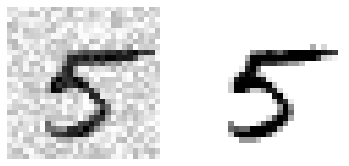

In [71]:
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

À esquerda temos a imagem confusa de entrada, e à direita está a imagem-alvo limpa.

Agora, vamos treinar o classificador para fazer com que ele limpe a imagem e chegue perto da imagem-alvo:

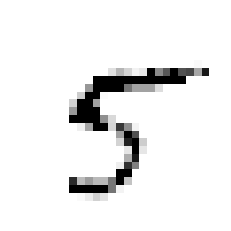

In [72]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

Parece bem próxima da imagem-alvo! Chegamos ao fim do nosso tour de classificações. Agora conseguimos saber quais são as metricas e selecionar as adequadas para os nossos projetos!

# Término: 20/09/2021